# Import

In [12]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, ReduceLROnPlateau
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [13]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.9

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 170

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 50

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [14]:
file_name

'MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [15]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [16]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
valid.transforms = ToTensor() 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [19]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [20]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [21]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [22]:
scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=10, factor=0.1, cooldown=50)

## (5) Define AMP scaler

In [23]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [24]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [25]:
optimizer.param_groups[0]["lr"]

0.1

In [26]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [27]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/170] :


1 Train: 100%|███████| 352/352 [01:32<00:00,  3.81it/s]

Train Loss: 2.3364 | Train Acc: 14.22%


Valid Loss: 2.1240 | Valid Acc: 19.56%
Test  Loss: 2.1913 | Test Acc: 18.79%
updated best eval loss : 2.1240122258663177
--------------------------------------------------
[Epoch 2/170] :


2 Train: 100%|███████| 352/352 [01:18<00:00,  4.50it/s]


Train Loss: 1.9733 | Train Acc: 25.46%
Valid Loss: 1.8866 | Valid Acc: 29.06%
Test  Loss: 2.2685 | Test Acc: 21.89%
updated best eval loss : 1.886613565683365
--------------------------------------------------
[Epoch 3/170] :


3 Train: 100%|███████| 352/352 [01:17<00:00,  4.57it/s]


Train Loss: 1.7193 | Train Acc: 36.37%
Valid Loss: 1.6321 | Valid Acc: 38.96%
Test  Loss: 1.7856 | Test Acc: 34.28%
updated best eval loss : 1.632055202126503
--------------------------------------------------
[Epoch 4/170] :


4 Train: 100%|███████| 352/352 [01:16<00:00,  4.60it/s]


Train Loss: 1.4156 | Train Acc: 49.05%
Valid Loss: 1.3270 | Valid Acc: 52.26%
Test  Loss: 1.8405 | Test Acc: 38.03%
updated best eval loss : 1.3269820362329483
--------------------------------------------------
[Epoch 5/170] :


5 Train: 100%|███████| 352/352 [01:17<00:00,  4.53it/s]


Train Loss: 1.1831 | Train Acc: 57.83%
Valid Loss: 1.1533 | Valid Acc: 58.66%
Test  Loss: 1.2062 | Test Acc: 57.74%
updated best eval loss : 1.1532513990998268
--------------------------------------------------
[Epoch 6/170] :


6 Train: 100%|███████| 352/352 [01:17<00:00,  4.54it/s]


Train Loss: 1.0560 | Train Acc: 62.80%
Valid Loss: 1.2827 | Valid Acc: 57.34%
Test  Loss: 1.2387 | Test Acc: 58.89%
--------------------------------------------------
[Epoch 7/170] :


7 Train: 100%|███████| 352/352 [01:17<00:00,  4.53it/s]


Train Loss: 0.9500 | Train Acc: 66.67%
Valid Loss: 1.1741 | Valid Acc: 60.42%
Test  Loss: 0.9736 | Test Acc: 67.48%
--------------------------------------------------
[Epoch 8/170] :


8 Train: 100%|███████| 352/352 [01:18<00:00,  4.48it/s]


Train Loss: 0.8896 | Train Acc: 69.09%
Valid Loss: 0.9501 | Valid Acc: 66.72%
Test  Loss: 0.8236 | Test Acc: 71.53%
updated best eval loss : 0.9501317858695983
--------------------------------------------------
[Epoch 9/170] :


9 Train: 100%|███████| 352/352 [01:16<00:00,  4.60it/s]


Train Loss: 0.8357 | Train Acc: 70.83%
Valid Loss: 0.8572 | Valid Acc: 70.60%
Test  Loss: 0.8117 | Test Acc: 72.00%
updated best eval loss : 0.8572280541062355
--------------------------------------------------
[Epoch 10/170] :


10 Train: 100%|██████| 352/352 [01:17<00:00,  4.53it/s]


Train Loss: 0.7922 | Train Acc: 72.39%
Valid Loss: 0.8334 | Valid Acc: 71.02%
Test  Loss: 1.1801 | Test Acc: 62.45%
updated best eval loss : 0.8334099873900414
--------------------------------------------------
[Epoch 11/170] :


11 Train: 100%|██████| 352/352 [01:18<00:00,  4.48it/s]


Train Loss: 0.7627 | Train Acc: 73.72%
Valid Loss: 0.8396 | Valid Acc: 71.02%
Test  Loss: 0.9360 | Test Acc: 68.85%
--------------------------------------------------
[Epoch 12/170] :


12 Train: 100%|██████| 352/352 [01:18<00:00,  4.48it/s]


Train Loss: 0.7345 | Train Acc: 74.50%
Valid Loss: 0.8499 | Valid Acc: 71.90%
Test  Loss: 0.8033 | Test Acc: 72.99%
--------------------------------------------------
[Epoch 13/170] :


13 Train: 100%|██████| 352/352 [01:19<00:00,  4.45it/s]


Train Loss: 0.7078 | Train Acc: 75.22%
Valid Loss: 0.7179 | Valid Acc: 74.50%
Test  Loss: 0.9456 | Test Acc: 68.97%
updated best eval loss : 0.7178579039871693
--------------------------------------------------
[Epoch 14/170] :


14 Train: 100%|██████| 352/352 [01:16<00:00,  4.62it/s]


Train Loss: 0.6951 | Train Acc: 75.71%
Valid Loss: 0.8197 | Valid Acc: 71.84%
Test  Loss: 0.7192 | Test Acc: 75.56%
--------------------------------------------------
[Epoch 15/170] :


15 Train: 100%|██████| 352/352 [01:16<00:00,  4.60it/s]


Train Loss: 0.6651 | Train Acc: 76.86%
Valid Loss: 0.7265 | Valid Acc: 74.50%
Test  Loss: 0.7157 | Test Acc: 75.82%
--------------------------------------------------
[Epoch 16/170] :


16 Train: 100%|██████| 352/352 [01:16<00:00,  4.63it/s]


Train Loss: 0.6530 | Train Acc: 77.49%
Valid Loss: 0.7695 | Valid Acc: 74.18%
Test  Loss: 0.7420 | Test Acc: 75.63%
--------------------------------------------------
[Epoch 17/170] :


17 Train: 100%|██████| 352/352 [01:16<00:00,  4.63it/s]


Train Loss: 0.6388 | Train Acc: 77.66%
Valid Loss: 0.7591 | Valid Acc: 74.34%
Test  Loss: 0.8192 | Test Acc: 72.01%
--------------------------------------------------
[Epoch 18/170] :


18 Train: 100%|██████| 352/352 [01:17<00:00,  4.52it/s]


Train Loss: 0.6299 | Train Acc: 78.16%
Valid Loss: 0.7921 | Valid Acc: 73.22%
Test  Loss: 0.8551 | Test Acc: 72.70%
--------------------------------------------------
[Epoch 19/170] :


19 Train: 100%|██████| 352/352 [01:17<00:00,  4.52it/s]


Train Loss: 0.6240 | Train Acc: 78.38%
Valid Loss: 0.8259 | Valid Acc: 72.28%
Test  Loss: 0.9214 | Test Acc: 70.58%
--------------------------------------------------
[Epoch 20/170] :


20 Train: 100%|██████| 352/352 [01:17<00:00,  4.54it/s]


Train Loss: 0.5971 | Train Acc: 79.29%
Valid Loss: 0.6979 | Valid Acc: 76.32%
Test  Loss: 0.8808 | Test Acc: 71.26%
updated best eval loss : 0.6978623166680336
--------------------------------------------------
[Epoch 21/170] :


21 Train: 100%|██████| 352/352 [01:18<00:00,  4.49it/s]


Train Loss: 0.5969 | Train Acc: 79.35%
Valid Loss: 0.7058 | Valid Acc: 75.92%
Test  Loss: 0.7674 | Test Acc: 75.12%
--------------------------------------------------
[Epoch 22/170] :


22 Train: 100%|██████| 352/352 [01:17<00:00,  4.54it/s]


Train Loss: 0.5775 | Train Acc: 80.04%
Valid Loss: 0.7385 | Valid Acc: 75.08%
Test  Loss: 0.7674 | Test Acc: 74.98%
--------------------------------------------------
[Epoch 23/170] :


23 Train: 100%|██████| 352/352 [01:16<00:00,  4.60it/s]


Train Loss: 0.5738 | Train Acc: 80.23%
Valid Loss: 0.6603 | Valid Acc: 77.02%
Test  Loss: 0.7005 | Test Acc: 76.31%
updated best eval loss : 0.6603358179330826
--------------------------------------------------
[Epoch 24/170] :


24 Train: 100%|██████| 352/352 [01:18<00:00,  4.50it/s]


Train Loss: 0.5634 | Train Acc: 80.43%
Valid Loss: 0.6913 | Valid Acc: 76.14%
Test  Loss: 0.8272 | Test Acc: 72.59%
--------------------------------------------------
[Epoch 25/170] :


25 Train: 100%|██████| 352/352 [01:17<00:00,  4.52it/s]


Train Loss: 0.5614 | Train Acc: 80.54%
Valid Loss: 0.6898 | Valid Acc: 76.68%
Test  Loss: 0.7581 | Test Acc: 74.51%
--------------------------------------------------
[Epoch 26/170] :


26 Train: 100%|██████| 352/352 [01:16<00:00,  4.60it/s]


Train Loss: 0.5501 | Train Acc: 80.83%
Valid Loss: 0.7362 | Valid Acc: 74.80%
Test  Loss: 1.0774 | Test Acc: 67.15%
--------------------------------------------------
[Epoch 27/170] :


27 Train: 100%|██████| 352/352 [01:17<00:00,  4.53it/s]


Train Loss: 0.5432 | Train Acc: 81.00%
Valid Loss: 0.6179 | Valid Acc: 78.06%
Test  Loss: 0.8458 | Test Acc: 71.18%
updated best eval loss : 0.617850660905242
--------------------------------------------------
[Epoch 28/170] :


28 Train: 100%|██████| 352/352 [01:15<00:00,  4.64it/s]


Train Loss: 0.5372 | Train Acc: 81.55%
Valid Loss: 0.7880 | Valid Acc: 74.24%
Test  Loss: 0.8430 | Test Acc: 73.58%
--------------------------------------------------
[Epoch 29/170] :


29 Train: 100%|██████| 352/352 [01:16<00:00,  4.58it/s]


Train Loss: 0.5316 | Train Acc: 81.62%
Valid Loss: 0.7362 | Valid Acc: 75.70%
Test  Loss: 0.7046 | Test Acc: 76.81%
--------------------------------------------------
[Epoch 30/170] :


30 Train: 100%|██████| 352/352 [01:17<00:00,  4.56it/s]


Train Loss: 0.5323 | Train Acc: 81.58%
Valid Loss: 0.6024 | Valid Acc: 79.20%
Test  Loss: 0.8906 | Test Acc: 70.61%
updated best eval loss : 0.6024097092449665
--------------------------------------------------
[Epoch 31/170] :


31 Train: 100%|██████| 352/352 [01:18<00:00,  4.50it/s]


Train Loss: 0.5307 | Train Acc: 81.65%
Valid Loss: 0.6650 | Valid Acc: 77.42%
Test  Loss: 0.6197 | Test Acc: 79.39%
--------------------------------------------------
[Epoch 32/170] :


32 Train: 100%|██████| 352/352 [01:16<00:00,  4.59it/s]


Train Loss: 0.5185 | Train Acc: 81.89%
Valid Loss: 0.6031 | Valid Acc: 79.02%
Test  Loss: 0.6890 | Test Acc: 75.94%
--------------------------------------------------
[Epoch 33/170] :


33 Train: 100%|██████| 352/352 [01:16<00:00,  4.61it/s]


Train Loss: 0.5187 | Train Acc: 81.91%
Valid Loss: 0.5997 | Valid Acc: 79.58%
Test  Loss: 0.8764 | Test Acc: 72.68%
updated best eval loss : 0.5997496705502272
--------------------------------------------------
[Epoch 34/170] :


34 Train: 100%|██████| 352/352 [01:16<00:00,  4.59it/s]


Train Loss: 0.5097 | Train Acc: 82.33%
Valid Loss: 0.6261 | Valid Acc: 77.82%
Test  Loss: 1.0192 | Test Acc: 68.22%
--------------------------------------------------
[Epoch 35/170] :


35 Train: 100%|██████| 352/352 [01:18<00:00,  4.47it/s]


Train Loss: 0.4977 | Train Acc: 82.64%
Valid Loss: 0.7659 | Valid Acc: 74.72%
Test  Loss: 0.9975 | Test Acc: 67.61%
--------------------------------------------------
[Epoch 36/170] :


36 Train: 100%|██████| 352/352 [01:17<00:00,  4.57it/s]


Train Loss: 0.5046 | Train Acc: 82.55%
Valid Loss: 0.5815 | Valid Acc: 80.06%
Test  Loss: 0.5938 | Test Acc: 79.53%
updated best eval loss : 0.5814682953059673
--------------------------------------------------
[Epoch 37/170] :


37 Train: 100%|██████| 352/352 [01:18<00:00,  4.47it/s]


Train Loss: 0.5030 | Train Acc: 82.58%
Valid Loss: 0.5905 | Valid Acc: 79.80%
Test  Loss: 0.6945 | Test Acc: 76.51%
--------------------------------------------------
[Epoch 38/170] :


38 Train: 100%|██████| 352/352 [01:16<00:00,  4.61it/s]


Train Loss: 0.4967 | Train Acc: 82.60%
Valid Loss: 0.6258 | Valid Acc: 78.82%
Test  Loss: 0.6420 | Test Acc: 78.51%
--------------------------------------------------
[Epoch 39/170] :


39 Train: 100%|██████| 352/352 [01:16<00:00,  4.61it/s]


Train Loss: 0.4894 | Train Acc: 82.92%
Valid Loss: 0.5898 | Valid Acc: 79.86%
Test  Loss: 0.8025 | Test Acc: 72.78%
--------------------------------------------------
[Epoch 40/170] :


40 Train: 100%|██████| 352/352 [01:16<00:00,  4.62it/s]


Train Loss: 0.4857 | Train Acc: 82.99%
Valid Loss: 0.6043 | Valid Acc: 79.72%
Test  Loss: 0.6222 | Test Acc: 79.87%
--------------------------------------------------
[Epoch 41/170] :


41 Train: 100%|██████| 352/352 [01:16<00:00,  4.61it/s]


Train Loss: 0.4788 | Train Acc: 83.27%
Valid Loss: 0.5805 | Valid Acc: 79.72%
Test  Loss: 0.8285 | Test Acc: 72.65%
updated best eval loss : 0.5805402867496013
--------------------------------------------------
[Epoch 42/170] :


42 Train: 100%|██████| 352/352 [01:08<00:00,  5.15it/s]


Train Loss: 0.4782 | Train Acc: 83.28%
Valid Loss: 0.6473 | Valid Acc: 79.10%
Test  Loss: 0.8337 | Test Acc: 73.44%
--------------------------------------------------
[Epoch 43/170] :


43 Train: 100%|██████| 352/352 [00:51<00:00,  6.87it/s]


Train Loss: 0.4767 | Train Acc: 83.40%
Valid Loss: 0.5457 | Valid Acc: 80.94%
Test  Loss: 0.5774 | Test Acc: 80.36%
updated best eval loss : 0.5456969279795885
--------------------------------------------------
[Epoch 44/170] :


44 Train: 100%|██████| 352/352 [00:43<00:00,  8.04it/s]


Train Loss: 0.4744 | Train Acc: 83.47%
Valid Loss: 0.6300 | Valid Acc: 78.42%
Test  Loss: 0.6345 | Test Acc: 78.80%
--------------------------------------------------
[Epoch 45/170] :


45 Train: 100%|██████| 352/352 [00:39<00:00,  8.90it/s]


Train Loss: 0.4703 | Train Acc: 83.52%
Valid Loss: 0.5799 | Valid Acc: 79.96%
Test  Loss: 0.8962 | Test Acc: 71.90%
--------------------------------------------------
[Epoch 46/170] :


46 Train: 100%|██████| 352/352 [00:39<00:00,  8.92it/s]


Train Loss: 0.4739 | Train Acc: 83.28%
Valid Loss: 0.6032 | Valid Acc: 79.70%
Test  Loss: 0.7897 | Test Acc: 73.71%
--------------------------------------------------
[Epoch 47/170] :


47 Train: 100%|██████| 352/352 [00:40<00:00,  8.79it/s]


Train Loss: 0.4621 | Train Acc: 84.01%
Valid Loss: 0.5853 | Valid Acc: 79.14%
Test  Loss: 0.6083 | Test Acc: 79.87%
--------------------------------------------------
[Epoch 48/170] :


48 Train: 100%|██████| 352/352 [00:39<00:00,  9.02it/s]


Train Loss: 0.4652 | Train Acc: 83.86%
Valid Loss: 0.5831 | Valid Acc: 80.02%
Test  Loss: 0.8108 | Test Acc: 72.15%
--------------------------------------------------
[Epoch 49/170] :


49 Train: 100%|██████| 352/352 [00:40<00:00,  8.77it/s]


Train Loss: 0.4593 | Train Acc: 83.99%
Valid Loss: 0.7624 | Valid Acc: 75.44%
Test  Loss: 1.0003 | Test Acc: 68.87%
--------------------------------------------------
[Epoch 50/170] :


50 Train: 100%|██████| 352/352 [00:39<00:00,  8.86it/s]


Train Loss: 0.4592 | Train Acc: 83.86%
Valid Loss: 0.5499 | Valid Acc: 81.36%
Test  Loss: 0.8984 | Test Acc: 72.98%
--------------------------------------------------
[Epoch 51/170] :


51 Train: 100%|██████| 352/352 [00:39<00:00,  8.90it/s]


Train Loss: 0.4579 | Train Acc: 84.21%
Valid Loss: 0.6051 | Valid Acc: 78.84%
Test  Loss: 0.6944 | Test Acc: 76.61%
--------------------------------------------------
[Epoch 52/170] :


52 Train: 100%|██████| 352/352 [00:39<00:00,  8.88it/s]


Train Loss: 0.4570 | Train Acc: 84.21%
Valid Loss: 0.5615 | Valid Acc: 81.40%
Test  Loss: 0.8076 | Test Acc: 74.69%
--------------------------------------------------
[Epoch 53/170] :


53 Train: 100%|██████| 352/352 [00:39<00:00,  8.90it/s]


Train Loss: 0.4483 | Train Acc: 84.53%
Valid Loss: 0.5992 | Valid Acc: 79.68%
Test  Loss: 0.8401 | Test Acc: 73.98%
--------------------------------------------------
[Epoch 54/170] :


54 Train: 100%|██████| 352/352 [00:39<00:00,  8.86it/s]


Train Loss: 0.4536 | Train Acc: 84.23%
Valid Loss: 0.5340 | Valid Acc: 81.90%
Test  Loss: 0.6557 | Test Acc: 78.41%
updated best eval loss : 0.5340198025107383
--------------------------------------------------
[Epoch 55/170] :


55 Train: 100%|██████| 352/352 [00:30<00:00, 11.67it/s]


Train Loss: 0.4451 | Train Acc: 84.45%
Valid Loss: 0.5990 | Valid Acc: 79.80%
Test  Loss: 0.6684 | Test Acc: 77.68%
--------------------------------------------------
[Epoch 56/170] :


56 Train: 100%|██████| 352/352 [00:30<00:00, 11.66it/s]


Train Loss: 0.4563 | Train Acc: 84.27%
Valid Loss: 0.6731 | Valid Acc: 77.88%
Test  Loss: 0.9186 | Test Acc: 70.42%
--------------------------------------------------
[Epoch 57/170] :


57 Train: 100%|██████| 352/352 [00:30<00:00, 11.68it/s]


Train Loss: 0.4485 | Train Acc: 84.58%
Valid Loss: 0.5805 | Valid Acc: 80.82%
Test  Loss: 0.5959 | Test Acc: 79.65%
--------------------------------------------------
[Epoch 58/170] :


58 Train: 100%|██████| 352/352 [00:29<00:00, 11.83it/s]


Train Loss: 0.4472 | Train Acc: 84.54%
Valid Loss: 0.5388 | Valid Acc: 81.50%
Test  Loss: 0.7471 | Test Acc: 75.89%
--------------------------------------------------
[Epoch 59/170] :


59 Train: 100%|██████| 352/352 [00:30<00:00, 11.67it/s]


Train Loss: 0.4448 | Train Acc: 84.45%
Valid Loss: 0.6477 | Valid Acc: 78.54%
Test  Loss: 0.7719 | Test Acc: 76.63%
--------------------------------------------------
[Epoch 60/170] :


60 Train: 100%|██████| 352/352 [00:29<00:00, 11.78it/s]


Train Loss: 0.4381 | Train Acc: 84.82%
Valid Loss: 0.6048 | Valid Acc: 80.42%
Test  Loss: 0.7238 | Test Acc: 76.61%
--------------------------------------------------
[Epoch 61/170] :


61 Train: 100%|██████| 352/352 [00:29<00:00, 11.79it/s]


Train Loss: 0.4315 | Train Acc: 85.05%
Valid Loss: 0.5870 | Valid Acc: 80.68%
Test  Loss: 0.6224 | Test Acc: 79.64%
--------------------------------------------------
[Epoch 62/170] :


62 Train: 100%|██████| 352/352 [00:30<00:00, 11.63it/s]


Train Loss: 0.4372 | Train Acc: 84.56%
Valid Loss: 0.6824 | Valid Acc: 78.10%
Test  Loss: 0.6731 | Test Acc: 78.24%
--------------------------------------------------
[Epoch 63/170] :


63 Train: 100%|██████| 352/352 [00:29<00:00, 11.83it/s]


Train Loss: 0.4296 | Train Acc: 85.10%
Valid Loss: 0.5378 | Valid Acc: 81.22%
Test  Loss: 0.4942 | Test Acc: 83.60%
--------------------------------------------------
[Epoch 64/170] :


64 Train: 100%|██████| 352/352 [00:29<00:00, 11.75it/s]


Train Loss: 0.4336 | Train Acc: 84.78%
Valid Loss: 0.5549 | Valid Acc: 81.06%
Test  Loss: 0.5065 | Test Acc: 83.02%
--------------------------------------------------
[Epoch 65/170] :


65 Train: 100%|██████| 352/352 [00:29<00:00, 11.78it/s]


Train Loss: 0.4321 | Train Acc: 84.89%
Valid Loss: 0.6714 | Valid Acc: 77.72%
Test  Loss: 0.8300 | Test Acc: 74.38%
--------------------------------------------------
[Epoch 66/170] :


66 Train: 100%|██████| 352/352 [00:29<00:00, 11.84it/s]


Train Loss: 0.3459 | Train Acc: 87.88%
Valid Loss: 0.4239 | Valid Acc: 85.60%
Test  Loss: 0.4637 | Test Acc: 83.98%
updated best eval loss : 0.42388358265161513
--------------------------------------------------
[Epoch 67/170] :


67 Train: 100%|██████| 352/352 [00:30<00:00, 11.66it/s]


Train Loss: 0.3101 | Train Acc: 89.21%
Valid Loss: 0.3847 | Valid Acc: 86.08%
Test  Loss: 0.4536 | Test Acc: 84.55%
updated best eval loss : 0.384715751092881
--------------------------------------------------
[Epoch 68/170] :


68 Train: 100%|██████| 352/352 [00:29<00:00, 11.77it/s]


Train Loss: 0.2953 | Train Acc: 89.77%
Valid Loss: 0.4106 | Valid Acc: 85.72%
Test  Loss: 0.4714 | Test Acc: 84.00%
--------------------------------------------------
[Epoch 69/170] :


69 Train: 100%|██████| 352/352 [00:29<00:00, 12.02it/s]


Train Loss: 0.2865 | Train Acc: 90.08%
Valid Loss: 0.4146 | Valid Acc: 86.00%
Test  Loss: 0.4608 | Test Acc: 84.26%
--------------------------------------------------
[Epoch 70/170] :


70 Train: 100%|██████| 352/352 [00:29<00:00, 11.83it/s]


Train Loss: 0.2878 | Train Acc: 90.12%
Valid Loss: 0.3832 | Valid Acc: 86.50%
Test  Loss: 0.4499 | Test Acc: 85.02%
updated best eval loss : 0.3831908795982599
--------------------------------------------------
[Epoch 71/170] :


71 Train: 100%|██████| 352/352 [00:29<00:00, 11.75it/s]


Train Loss: 0.2793 | Train Acc: 90.36%
Valid Loss: 0.3804 | Valid Acc: 87.34%
Test  Loss: 0.4529 | Test Acc: 84.98%
updated best eval loss : 0.38038427717983725
--------------------------------------------------
[Epoch 72/170] :


72 Train: 100%|██████| 352/352 [00:29<00:00, 11.97it/s]


Train Loss: 0.2767 | Train Acc: 90.42%
Valid Loss: 0.4025 | Valid Acc: 86.26%
Test  Loss: 0.4345 | Test Acc: 85.82%
--------------------------------------------------
[Epoch 73/170] :


73 Train: 100%|██████| 352/352 [00:30<00:00, 11.64it/s]


Train Loss: 0.2721 | Train Acc: 90.56%
Valid Loss: 0.3949 | Valid Acc: 86.78%
Test  Loss: 0.4532 | Test Acc: 85.26%
--------------------------------------------------
[Epoch 74/170] :


74 Train: 100%|██████| 352/352 [00:29<00:00, 11.91it/s]


Train Loss: 0.2685 | Train Acc: 90.71%
Valid Loss: 0.3805 | Valid Acc: 86.60%
Test  Loss: 0.4840 | Test Acc: 84.28%
--------------------------------------------------
[Epoch 75/170] :


75 Train: 100%|██████| 352/352 [00:30<00:00, 11.72it/s]


Train Loss: 0.2645 | Train Acc: 90.95%
Valid Loss: 0.3783 | Valid Acc: 87.02%
Test  Loss: 0.4648 | Test Acc: 84.93%
updated best eval loss : 0.37833471447229383
--------------------------------------------------
[Epoch 76/170] :


76 Train: 100%|██████| 352/352 [00:29<00:00, 11.88it/s]


Train Loss: 0.2670 | Train Acc: 90.74%
Valid Loss: 0.3832 | Valid Acc: 86.84%
Test  Loss: 0.4881 | Test Acc: 83.84%
--------------------------------------------------
[Epoch 77/170] :


77 Train: 100%|██████| 352/352 [00:29<00:00, 11.75it/s]


Train Loss: 0.2592 | Train Acc: 90.96%
Valid Loss: 0.4162 | Valid Acc: 86.62%
Test  Loss: 0.4990 | Test Acc: 84.11%
--------------------------------------------------
[Epoch 78/170] :


78 Train: 100%|██████| 352/352 [00:29<00:00, 11.78it/s]


Train Loss: 0.2548 | Train Acc: 91.10%
Valid Loss: 0.3901 | Valid Acc: 87.02%
Test  Loss: 0.5988 | Test Acc: 81.07%
--------------------------------------------------
[Epoch 79/170] :


79 Train: 100%|██████| 352/352 [00:29<00:00, 11.83it/s]


Train Loss: 0.2540 | Train Acc: 91.31%
Valid Loss: 0.3794 | Valid Acc: 87.26%
Test  Loss: 0.4941 | Test Acc: 83.84%
--------------------------------------------------
[Epoch 80/170] :


80 Train: 100%|██████| 352/352 [00:29<00:00, 11.92it/s]


Train Loss: 0.2494 | Train Acc: 91.34%
Valid Loss: 0.4061 | Valid Acc: 87.02%
Test  Loss: 0.6525 | Test Acc: 80.45%
--------------------------------------------------
[Epoch 81/170] :


81 Train: 100%|██████| 352/352 [00:29<00:00, 11.92it/s]


Train Loss: 0.2524 | Train Acc: 91.20%
Valid Loss: 0.3836 | Valid Acc: 86.92%
Test  Loss: 0.5444 | Test Acc: 82.82%
--------------------------------------------------
[Epoch 82/170] :


82 Train: 100%|██████| 352/352 [00:29<00:00, 11.88it/s]


Train Loss: 0.2472 | Train Acc: 91.44%
Valid Loss: 0.4084 | Valid Acc: 87.06%
Test  Loss: 0.5305 | Test Acc: 83.48%
--------------------------------------------------
[Epoch 83/170] :


83 Train: 100%|██████| 352/352 [00:29<00:00, 11.89it/s]


Train Loss: 0.2544 | Train Acc: 91.17%
Valid Loss: 0.3797 | Valid Acc: 87.36%
Test  Loss: 0.5008 | Test Acc: 84.09%
--------------------------------------------------
[Epoch 84/170] :


84 Train: 100%|██████| 352/352 [00:29<00:00, 11.77it/s]


Train Loss: 0.2443 | Train Acc: 91.49%
Valid Loss: 0.3748 | Valid Acc: 87.12%
Test  Loss: 0.4832 | Test Acc: 84.38%
updated best eval loss : 0.37484555393457414
--------------------------------------------------
[Epoch 85/170] :


85 Train: 100%|██████| 352/352 [00:29<00:00, 11.83it/s]


Train Loss: 0.2444 | Train Acc: 91.46%
Valid Loss: 0.3746 | Valid Acc: 87.50%
Test  Loss: 0.4753 | Test Acc: 84.58%
updated best eval loss : 0.37455645129084586
--------------------------------------------------
[Epoch 86/170] :


86 Train: 100%|██████| 352/352 [00:30<00:00, 11.57it/s]


Train Loss: 0.2408 | Train Acc: 91.51%
Valid Loss: 0.3817 | Valid Acc: 87.06%
Test  Loss: 0.5150 | Test Acc: 84.04%
--------------------------------------------------
[Epoch 87/170] :


87 Train: 100%|██████| 352/352 [00:29<00:00, 11.79it/s]


Train Loss: 0.2368 | Train Acc: 91.74%
Valid Loss: 0.4044 | Valid Acc: 86.74%
Test  Loss: 0.5974 | Test Acc: 81.77%
--------------------------------------------------
[Epoch 88/170] :


88 Train: 100%|██████| 352/352 [00:29<00:00, 11.73it/s]


Train Loss: 0.2404 | Train Acc: 91.68%
Valid Loss: 0.3826 | Valid Acc: 87.28%
Test  Loss: 0.5452 | Test Acc: 83.28%
--------------------------------------------------
[Epoch 89/170] :


89 Train: 100%|██████| 352/352 [00:29<00:00, 11.80it/s]


Train Loss: 0.2406 | Train Acc: 91.58%
Valid Loss: 0.3859 | Valid Acc: 87.22%
Test  Loss: 0.5449 | Test Acc: 83.56%
--------------------------------------------------
[Epoch 90/170] :


90 Train: 100%|██████| 352/352 [00:29<00:00, 12.05it/s]


Train Loss: 0.2376 | Train Acc: 91.68%
Valid Loss: 0.3883 | Valid Acc: 86.58%
Test  Loss: 0.5335 | Test Acc: 83.21%
--------------------------------------------------
[Epoch 91/170] :


91 Train: 100%|██████| 352/352 [00:29<00:00, 11.75it/s]


Train Loss: 0.2384 | Train Acc: 91.63%
Valid Loss: 0.3914 | Valid Acc: 87.00%
Test  Loss: 0.4957 | Test Acc: 84.28%
--------------------------------------------------
[Epoch 92/170] :


92 Train: 100%|██████| 352/352 [00:29<00:00, 11.96it/s]


Train Loss: 0.2358 | Train Acc: 91.66%
Valid Loss: 0.3885 | Valid Acc: 87.24%
Test  Loss: 0.5737 | Test Acc: 82.29%
--------------------------------------------------
[Epoch 93/170] :


93 Train: 100%|██████| 352/352 [00:29<00:00, 11.78it/s]


Train Loss: 0.2335 | Train Acc: 91.83%
Valid Loss: 0.3773 | Valid Acc: 87.54%
Test  Loss: 0.4913 | Test Acc: 84.59%
--------------------------------------------------
[Epoch 94/170] :


94 Train: 100%|██████| 352/352 [00:29<00:00, 12.06it/s]


Train Loss: 0.2325 | Train Acc: 92.01%
Valid Loss: 0.4006 | Valid Acc: 86.50%
Test  Loss: 0.5538 | Test Acc: 82.89%
--------------------------------------------------
[Epoch 95/170] :


95 Train: 100%|██████| 352/352 [00:29<00:00, 11.95it/s]


Train Loss: 0.2313 | Train Acc: 91.88%
Valid Loss: 0.4246 | Valid Acc: 87.16%
Test  Loss: 0.5458 | Test Acc: 83.44%
--------------------------------------------------
[Epoch 96/170] :


96 Train: 100%|██████| 352/352 [00:29<00:00, 11.80it/s]


Train Loss: 0.2278 | Train Acc: 92.06%
Valid Loss: 0.3954 | Valid Acc: 87.16%
Test  Loss: 0.5157 | Test Acc: 83.89%
--------------------------------------------------
[Epoch 97/170] :


97 Train: 100%|██████| 352/352 [00:29<00:00, 11.95it/s]


Train Loss: 0.2319 | Train Acc: 91.85%
Valid Loss: 0.4020 | Valid Acc: 87.32%
Test  Loss: 0.5625 | Test Acc: 82.53%
--------------------------------------------------
[Epoch 98/170] :


98 Train: 100%|██████| 352/352 [00:29<00:00, 11.88it/s]


Train Loss: 0.2265 | Train Acc: 92.26%
Valid Loss: 0.3964 | Valid Acc: 87.22%
Test  Loss: 0.5491 | Test Acc: 82.61%
--------------------------------------------------
[Epoch 99/170] :


99 Train: 100%|██████| 352/352 [00:29<00:00, 11.85it/s]


Train Loss: 0.2262 | Train Acc: 92.10%
Valid Loss: 0.3791 | Valid Acc: 87.10%
Test  Loss: 0.5159 | Test Acc: 83.67%
--------------------------------------------------
[Epoch 100/170] :


100 Train: 100%|█████| 352/352 [00:30<00:00, 11.72it/s]


Train Loss: 0.2275 | Train Acc: 92.19%
Valid Loss: 0.4160 | Valid Acc: 86.74%
Test  Loss: 0.5109 | Test Acc: 83.75%
--------------------------------------------------
[Epoch 101/170] :


101 Train: 100%|█████| 352/352 [00:29<00:00, 11.88it/s]


Train Loss: 0.2209 | Train Acc: 92.26%
Valid Loss: 0.3987 | Valid Acc: 87.16%
Test  Loss: 0.5480 | Test Acc: 83.09%
--------------------------------------------------
[Epoch 102/170] :


102 Train: 100%|█████| 352/352 [00:29<00:00, 11.95it/s]


Train Loss: 0.2239 | Train Acc: 92.24%
Valid Loss: 0.3878 | Valid Acc: 87.42%
Test  Loss: 0.5902 | Test Acc: 82.08%
--------------------------------------------------
[Epoch 103/170] :


103 Train: 100%|█████| 352/352 [00:29<00:00, 11.97it/s]


Train Loss: 0.2178 | Train Acc: 92.40%
Valid Loss: 0.3975 | Valid Acc: 87.30%
Test  Loss: 0.5691 | Test Acc: 82.82%
--------------------------------------------------
[Epoch 104/170] :


104 Train: 100%|█████| 352/352 [00:30<00:00, 11.65it/s]


Train Loss: 0.2232 | Train Acc: 92.32%
Valid Loss: 0.3678 | Valid Acc: 87.58%
Test  Loss: 0.4728 | Test Acc: 84.94%
updated best eval loss : 0.36775589832104744
--------------------------------------------------
[Epoch 105/170] :


105 Train: 100%|█████| 352/352 [00:29<00:00, 11.80it/s]


Train Loss: 0.2188 | Train Acc: 92.36%
Valid Loss: 0.3853 | Valid Acc: 87.44%
Test  Loss: 0.5498 | Test Acc: 83.14%
--------------------------------------------------
[Epoch 106/170] :


106 Train: 100%|█████| 352/352 [00:30<00:00, 11.72it/s]


Train Loss: 0.2192 | Train Acc: 92.45%
Valid Loss: 0.4227 | Valid Acc: 86.66%
Test  Loss: 0.5050 | Test Acc: 84.18%
--------------------------------------------------
[Epoch 107/170] :


107 Train: 100%|█████| 352/352 [00:29<00:00, 11.94it/s]


Train Loss: 0.2182 | Train Acc: 92.32%
Valid Loss: 0.3983 | Valid Acc: 86.70%
Test  Loss: 0.4954 | Test Acc: 84.65%
--------------------------------------------------
[Epoch 108/170] :


108 Train: 100%|█████| 352/352 [00:30<00:00, 11.71it/s]


Train Loss: 0.2206 | Train Acc: 92.19%
Valid Loss: 0.4132 | Valid Acc: 87.00%
Test  Loss: 0.5356 | Test Acc: 83.53%
--------------------------------------------------
[Epoch 109/170] :


109 Train: 100%|█████| 352/352 [00:29<00:00, 11.76it/s]


Train Loss: 0.2136 | Train Acc: 92.56%
Valid Loss: 0.3876 | Valid Acc: 87.24%
Test  Loss: 0.5354 | Test Acc: 83.63%
--------------------------------------------------
[Epoch 110/170] :


110 Train: 100%|█████| 352/352 [00:29<00:00, 11.86it/s]


Train Loss: 0.2160 | Train Acc: 92.52%
Valid Loss: 0.4001 | Valid Acc: 87.32%
Test  Loss: 0.4578 | Test Acc: 85.64%
--------------------------------------------------
[Epoch 111/170] :


111 Train: 100%|█████| 352/352 [00:29<00:00, 11.79it/s]


Train Loss: 0.2222 | Train Acc: 92.21%
Valid Loss: 0.3989 | Valid Acc: 87.20%
Test  Loss: 0.4555 | Test Acc: 85.95%
--------------------------------------------------
[Epoch 112/170] :


112 Train: 100%|█████| 352/352 [00:29<00:00, 11.77it/s]


Train Loss: 0.2176 | Train Acc: 92.44%
Valid Loss: 0.3698 | Valid Acc: 87.56%
Test  Loss: 0.5487 | Test Acc: 83.94%
--------------------------------------------------
[Epoch 113/170] :


113 Train: 100%|█████| 352/352 [00:29<00:00, 11.74it/s]


Train Loss: 0.2152 | Train Acc: 92.40%
Valid Loss: 0.3887 | Valid Acc: 86.98%
Test  Loss: 0.4996 | Test Acc: 84.66%
--------------------------------------------------
[Epoch 114/170] :


114 Train: 100%|█████| 352/352 [00:29<00:00, 11.82it/s]


Train Loss: 0.2156 | Train Acc: 92.54%
Valid Loss: 0.3828 | Valid Acc: 87.46%
Test  Loss: 0.5576 | Test Acc: 83.14%
--------------------------------------------------
[Epoch 115/170] :


115 Train: 100%|█████| 352/352 [00:30<00:00, 11.50it/s]


Train Loss: 0.2131 | Train Acc: 92.52%
Valid Loss: 0.4083 | Valid Acc: 87.46%
Test  Loss: 0.5962 | Test Acc: 81.98%
--------------------------------------------------
[Epoch 116/170] :


116 Train: 100%|█████| 352/352 [00:29<00:00, 12.02it/s]


Train Loss: 0.2166 | Train Acc: 92.54%
Valid Loss: 0.3978 | Valid Acc: 87.14%
Test  Loss: 0.6230 | Test Acc: 81.52%
--------------------------------------------------
[Epoch 117/170] :


117 Train: 100%|█████| 352/352 [00:29<00:00, 11.79it/s]


Train Loss: 0.2133 | Train Acc: 92.60%
Valid Loss: 0.3748 | Valid Acc: 87.62%
Test  Loss: 0.5696 | Test Acc: 83.29%
--------------------------------------------------
[Epoch 118/170] :


118 Train: 100%|█████| 352/352 [00:29<00:00, 11.90it/s]


Train Loss: 0.2132 | Train Acc: 92.54%
Valid Loss: 0.4195 | Valid Acc: 86.80%
Test  Loss: 0.6464 | Test Acc: 81.42%
--------------------------------------------------
[Epoch 119/170] :


119 Train: 100%|█████| 352/352 [00:29<00:00, 11.77it/s]


Train Loss: 0.2103 | Train Acc: 92.72%
Valid Loss: 0.3863 | Valid Acc: 87.68%
Test  Loss: 0.5708 | Test Acc: 83.29%
--------------------------------------------------
[Epoch 120/170] :


120 Train: 100%|█████| 352/352 [00:29<00:00, 11.82it/s]


Train Loss: 0.2122 | Train Acc: 92.64%
Valid Loss: 0.3989 | Valid Acc: 86.96%
Test  Loss: 0.5464 | Test Acc: 83.76%
--------------------------------------------------
[Epoch 121/170] :


121 Train: 100%|█████| 352/352 [00:29<00:00, 11.82it/s]


Train Loss: 0.2114 | Train Acc: 92.71%
Valid Loss: 0.4088 | Valid Acc: 87.50%
Test  Loss: 0.5015 | Test Acc: 84.30%
--------------------------------------------------
[Epoch 122/170] :


122 Train: 100%|█████| 352/352 [00:29<00:00, 11.78it/s]


Train Loss: 0.2044 | Train Acc: 92.93%
Valid Loss: 0.3891 | Valid Acc: 87.68%
Test  Loss: 0.5288 | Test Acc: 83.84%
--------------------------------------------------
[Epoch 123/170] :


123 Train: 100%|█████| 352/352 [00:29<00:00, 11.76it/s]


Train Loss: 0.2109 | Train Acc: 92.66%
Valid Loss: 0.3925 | Valid Acc: 87.04%
Test  Loss: 0.4850 | Test Acc: 85.08%
--------------------------------------------------
[Epoch 124/170] :


124 Train: 100%|█████| 352/352 [00:29<00:00, 11.76it/s]


Train Loss: 0.2077 | Train Acc: 92.75%
Valid Loss: 0.4291 | Valid Acc: 87.06%
Test  Loss: 0.5272 | Test Acc: 84.15%
--------------------------------------------------
[Epoch 125/170] :


125 Train: 100%|█████| 352/352 [00:30<00:00, 11.70it/s]


Train Loss: 0.2060 | Train Acc: 92.68%
Valid Loss: 0.3943 | Valid Acc: 87.58%
Test  Loss: 0.5633 | Test Acc: 82.37%
--------------------------------------------------
[Epoch 126/170] :


126 Train: 100%|█████| 352/352 [00:29<00:00, 11.88it/s]


Train Loss: 0.2086 | Train Acc: 92.75%
Valid Loss: 0.4305 | Valid Acc: 87.00%
Test  Loss: 0.5902 | Test Acc: 82.51%
--------------------------------------------------
[Epoch 127/170] :


127 Train: 100%|█████| 352/352 [00:29<00:00, 11.84it/s]


Train Loss: 0.1983 | Train Acc: 93.17%
Valid Loss: 0.3735 | Valid Acc: 88.08%
Test  Loss: 0.5339 | Test Acc: 84.01%
--------------------------------------------------
[Epoch 128/170] :


128 Train: 100%|█████| 352/352 [00:29<00:00, 11.78it/s]


Train Loss: 0.1907 | Train Acc: 93.46%
Valid Loss: 0.3760 | Valid Acc: 87.92%
Test  Loss: 0.5293 | Test Acc: 84.07%
--------------------------------------------------
[Epoch 129/170] :


129 Train: 100%|█████| 352/352 [00:30<00:00, 11.72it/s]


Train Loss: 0.1878 | Train Acc: 93.60%
Valid Loss: 0.4360 | Valid Acc: 87.32%
Test  Loss: 0.5499 | Test Acc: 83.62%
--------------------------------------------------
[Epoch 130/170] :


130 Train: 100%|█████| 352/352 [00:29<00:00, 11.81it/s]


Train Loss: 0.1873 | Train Acc: 93.61%
Valid Loss: 0.3772 | Valid Acc: 87.20%
Test  Loss: 0.5432 | Test Acc: 83.91%
--------------------------------------------------
[Epoch 131/170] :


131 Train: 100%|█████| 352/352 [00:29<00:00, 11.76it/s]


Train Loss: 0.1818 | Train Acc: 93.68%
Valid Loss: 0.3962 | Valid Acc: 87.40%
Test  Loss: 0.5680 | Test Acc: 83.28%
--------------------------------------------------
[Epoch 132/170] :


132 Train: 100%|█████| 352/352 [00:29<00:00, 11.97it/s]


Train Loss: 0.1886 | Train Acc: 93.56%
Valid Loss: 0.3561 | Valid Acc: 88.00%
Test  Loss: 0.5530 | Test Acc: 83.15%
updated best eval loss : 0.3560540061444044
--------------------------------------------------
[Epoch 133/170] :


133 Train: 100%|█████| 352/352 [00:29<00:00, 11.96it/s]


Train Loss: 0.1852 | Train Acc: 93.61%
Valid Loss: 0.3721 | Valid Acc: 88.48%
Test  Loss: 0.5540 | Test Acc: 83.32%
--------------------------------------------------
[Epoch 134/170] :


134 Train: 100%|█████| 352/352 [00:16<00:00, 21.18it/s]


Train Loss: 0.1819 | Train Acc: 93.79%
Valid Loss: 0.3735 | Valid Acc: 87.96%
Test  Loss: 0.5634 | Test Acc: 82.96%
--------------------------------------------------
[Epoch 135/170] :


135 Train: 100%|█████| 352/352 [00:16<00:00, 21.12it/s]


Train Loss: 0.1807 | Train Acc: 93.92%
Valid Loss: 0.3490 | Valid Acc: 88.84%
Test  Loss: 0.5563 | Test Acc: 83.19%
updated best eval loss : 0.34896242916584014
--------------------------------------------------
[Epoch 136/170] :


136 Train: 100%|█████| 352/352 [00:16<00:00, 21.68it/s]


Train Loss: 0.1821 | Train Acc: 93.70%
Valid Loss: 0.3821 | Valid Acc: 87.62%
Test  Loss: 0.5582 | Test Acc: 83.30%
--------------------------------------------------
[Epoch 137/170] :


137 Train: 100%|█████| 352/352 [00:16<00:00, 21.10it/s]


Train Loss: 0.1828 | Train Acc: 93.73%
Valid Loss: 0.3800 | Valid Acc: 87.66%
Test  Loss: 0.5474 | Test Acc: 83.58%
--------------------------------------------------
[Epoch 138/170] :


138 Train: 100%|█████| 352/352 [00:16<00:00, 21.07it/s]


Train Loss: 0.1793 | Train Acc: 93.86%
Valid Loss: 0.3522 | Valid Acc: 87.72%
Test  Loss: 0.6076 | Test Acc: 82.44%
--------------------------------------------------
[Epoch 139/170] :


139 Train: 100%|█████| 352/352 [00:16<00:00, 21.19it/s]


Train Loss: 0.1802 | Train Acc: 93.82%
Valid Loss: 0.3865 | Valid Acc: 87.68%
Test  Loss: 0.5830 | Test Acc: 82.79%
--------------------------------------------------
[Epoch 140/170] :


140 Train: 100%|█████| 352/352 [00:16<00:00, 21.63it/s]


Train Loss: 0.1737 | Train Acc: 94.03%
Valid Loss: 0.3628 | Valid Acc: 88.04%
Test  Loss: 0.5872 | Test Acc: 82.75%
--------------------------------------------------
[Epoch 141/170] :


141 Train: 100%|█████| 352/352 [00:16<00:00, 21.23it/s]


Train Loss: 0.1836 | Train Acc: 93.68%
Valid Loss: 0.3911 | Valid Acc: 88.16%
Test  Loss: 0.5830 | Test Acc: 82.81%
--------------------------------------------------
[Epoch 142/170] :


142 Train: 100%|█████| 352/352 [00:16<00:00, 21.13it/s]


Train Loss: 0.1782 | Train Acc: 93.92%
Valid Loss: 0.3771 | Valid Acc: 88.18%
Test  Loss: 0.5662 | Test Acc: 83.21%
--------------------------------------------------
[Epoch 143/170] :


143 Train: 100%|█████| 352/352 [00:16<00:00, 21.00it/s]


Train Loss: 0.1800 | Train Acc: 93.77%
Valid Loss: 0.3919 | Valid Acc: 87.78%
Test  Loss: 0.5813 | Test Acc: 82.95%
--------------------------------------------------
[Epoch 144/170] :


144 Train: 100%|█████| 352/352 [00:16<00:00, 21.38it/s]


Train Loss: 0.1783 | Train Acc: 93.78%
Valid Loss: 0.3755 | Valid Acc: 87.88%
Test  Loss: 0.5910 | Test Acc: 82.39%
--------------------------------------------------
[Epoch 145/170] :


145 Train: 100%|█████| 352/352 [00:16<00:00, 21.42it/s]


Train Loss: 0.1791 | Train Acc: 93.89%
Valid Loss: 0.3540 | Valid Acc: 88.54%
Test  Loss: 0.6096 | Test Acc: 82.33%
--------------------------------------------------
[Epoch 146/170] :


146 Train: 100%|█████| 352/352 [00:16<00:00, 21.46it/s]


Train Loss: 0.1791 | Train Acc: 93.84%
Valid Loss: 0.3873 | Valid Acc: 88.02%
Test  Loss: 0.5950 | Test Acc: 82.55%
--------------------------------------------------
[Epoch 147/170] :


147 Train: 100%|█████| 352/352 [00:16<00:00, 20.98it/s]


Train Loss: 0.1790 | Train Acc: 93.93%
Valid Loss: 0.3604 | Valid Acc: 88.06%
Test  Loss: 0.6463 | Test Acc: 81.65%
--------------------------------------------------
[Epoch 148/170] :


148 Train: 100%|█████| 352/352 [00:16<00:00, 21.70it/s]


Train Loss: 0.1797 | Train Acc: 93.76%
Valid Loss: 0.3683 | Valid Acc: 88.24%
Test  Loss: 0.6109 | Test Acc: 82.16%
--------------------------------------------------
[Epoch 149/170] :


149 Train: 100%|█████| 352/352 [00:16<00:00, 20.83it/s]


Train Loss: 0.1796 | Train Acc: 93.74%
Valid Loss: 0.3757 | Valid Acc: 87.96%
Test  Loss: 0.6150 | Test Acc: 81.97%
--------------------------------------------------
[Epoch 150/170] :


150 Train: 100%|█████| 352/352 [00:16<00:00, 21.17it/s]


Train Loss: 0.1811 | Train Acc: 93.79%
Valid Loss: 0.3498 | Valid Acc: 88.28%
Test  Loss: 0.6402 | Test Acc: 81.52%
--------------------------------------------------
[Epoch 151/170] :


151 Train: 100%|█████| 352/352 [00:16<00:00, 21.17it/s]


Train Loss: 0.1817 | Train Acc: 93.72%
Valid Loss: 0.3622 | Valid Acc: 88.42%
Test  Loss: 0.6486 | Test Acc: 81.25%
--------------------------------------------------
[Epoch 152/170] :


152 Train: 100%|█████| 352/352 [00:16<00:00, 20.83it/s]


Train Loss: 0.1788 | Train Acc: 93.86%
Valid Loss: 0.3947 | Valid Acc: 87.32%
Test  Loss: 0.5940 | Test Acc: 82.35%
--------------------------------------------------
[Epoch 153/170] :


153 Train: 100%|█████| 352/352 [00:16<00:00, 21.00it/s]


Train Loss: 0.1764 | Train Acc: 93.94%
Valid Loss: 0.3749 | Valid Acc: 88.48%
Test  Loss: 0.5887 | Test Acc: 82.52%
--------------------------------------------------
[Epoch 154/170] :


154 Train: 100%|█████| 352/352 [00:16<00:00, 21.31it/s]


Train Loss: 0.1781 | Train Acc: 93.93%
Valid Loss: 0.3892 | Valid Acc: 87.70%
Test  Loss: 0.5948 | Test Acc: 82.55%
--------------------------------------------------
[Epoch 155/170] :


155 Train: 100%|█████| 352/352 [00:16<00:00, 21.17it/s]


Train Loss: 0.1752 | Train Acc: 93.98%
Valid Loss: 0.3659 | Valid Acc: 87.82%
Test  Loss: 0.6055 | Test Acc: 82.06%
--------------------------------------------------
[Epoch 156/170] :


156 Train: 100%|█████| 352/352 [00:16<00:00, 21.14it/s]


Train Loss: 0.1776 | Train Acc: 93.84%
Valid Loss: 0.3757 | Valid Acc: 87.98%
Test  Loss: 0.6239 | Test Acc: 82.15%
--------------------------------------------------
[Epoch 157/170] :


157 Train: 100%|█████| 352/352 [00:16<00:00, 21.22it/s]


Train Loss: 0.1780 | Train Acc: 93.78%
Valid Loss: 0.3748 | Valid Acc: 87.72%
Test  Loss: 0.6047 | Test Acc: 82.33%
--------------------------------------------------
[Epoch 158/170] :


158 Train: 100%|█████| 352/352 [00:16<00:00, 21.24it/s]


Train Loss: 0.1736 | Train Acc: 94.08%
Valid Loss: 0.3687 | Valid Acc: 87.76%
Test  Loss: 0.5814 | Test Acc: 83.01%
--------------------------------------------------
[Epoch 159/170] :


159 Train: 100%|█████| 352/352 [00:16<00:00, 20.95it/s]


Train Loss: 0.1742 | Train Acc: 94.11%
Valid Loss: 0.3713 | Valid Acc: 88.34%
Test  Loss: 0.6114 | Test Acc: 82.16%
--------------------------------------------------
[Epoch 160/170] :


160 Train: 100%|█████| 352/352 [00:16<00:00, 21.22it/s]


Train Loss: 0.1793 | Train Acc: 93.88%
Valid Loss: 0.3491 | Valid Acc: 88.62%
Test  Loss: 0.6156 | Test Acc: 82.28%
--------------------------------------------------
[Epoch 161/170] :


161 Train: 100%|█████| 352/352 [00:16<00:00, 20.98it/s]


Train Loss: 0.1709 | Train Acc: 94.24%
Valid Loss: 0.3723 | Valid Acc: 88.00%
Test  Loss: 0.6313 | Test Acc: 81.96%
--------------------------------------------------
[Epoch 162/170] :


162 Train: 100%|█████| 352/352 [00:16<00:00, 21.08it/s]


Train Loss: 0.1723 | Train Acc: 94.00%
Valid Loss: 0.3655 | Valid Acc: 87.70%
Test  Loss: 0.5914 | Test Acc: 82.68%
--------------------------------------------------
[Epoch 163/170] :


163 Train: 100%|█████| 352/352 [00:16<00:00, 20.97it/s]


Train Loss: 0.1738 | Train Acc: 94.01%
Valid Loss: 0.3544 | Valid Acc: 88.54%
Test  Loss: 0.5860 | Test Acc: 82.70%
--------------------------------------------------
[Epoch 164/170] :


164 Train: 100%|█████| 352/352 [00:16<00:00, 21.40it/s]


Train Loss: 0.1761 | Train Acc: 93.88%
Valid Loss: 0.3679 | Valid Acc: 87.72%
Test  Loss: 0.5900 | Test Acc: 82.58%
--------------------------------------------------
[Epoch 165/170] :


165 Train: 100%|█████| 352/352 [00:16<00:00, 21.33it/s]


Train Loss: 0.1732 | Train Acc: 94.09%
Valid Loss: 0.3585 | Valid Acc: 88.20%
Test  Loss: 0.6012 | Test Acc: 82.74%
--------------------------------------------------
[Epoch 166/170] :


166 Train: 100%|█████| 352/352 [00:16<00:00, 21.43it/s]


Train Loss: 0.1720 | Train Acc: 94.08%
Valid Loss: 0.3840 | Valid Acc: 87.88%
Test  Loss: 0.6019 | Test Acc: 82.29%
--------------------------------------------------
[Epoch 167/170] :


167 Train: 100%|█████| 352/352 [00:16<00:00, 21.15it/s]


Train Loss: 0.1722 | Train Acc: 94.10%
Valid Loss: 0.3800 | Valid Acc: 87.86%
Test  Loss: 0.6137 | Test Acc: 82.45%
--------------------------------------------------
[Epoch 168/170] :


168 Train: 100%|█████| 352/352 [00:16<00:00, 20.84it/s]


Train Loss: 0.1758 | Train Acc: 93.96%
Valid Loss: 0.3741 | Valid Acc: 88.10%
Test  Loss: 0.6046 | Test Acc: 82.57%
--------------------------------------------------
[Epoch 169/170] :


169 Train: 100%|█████| 352/352 [00:16<00:00, 21.26it/s]


Train Loss: 0.1756 | Train Acc: 93.95%
Valid Loss: 0.3712 | Valid Acc: 87.42%
Test  Loss: 0.6319 | Test Acc: 82.11%
--------------------------------------------------
[Epoch 170/170] :


170 Train: 100%|█████| 352/352 [00:16<00:00, 21.36it/s]


Train Loss: 0.1738 | Train Acc: 94.18%
Valid Loss: 0.3962 | Valid Acc: 87.98%
Test  Loss: 0.6312 | Test Acc: 81.69%
--------------------------------------------------


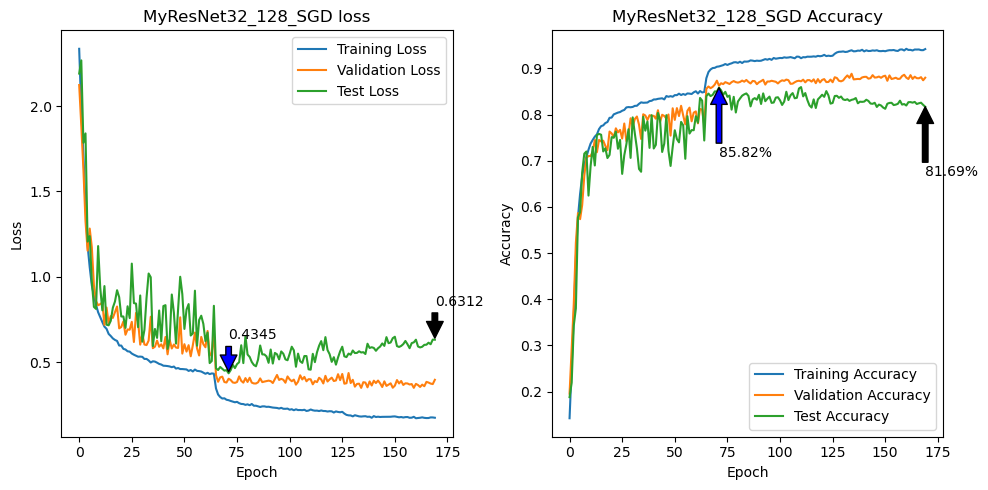

In [28]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [29]:
view.print_all()

1 epoch: train_loss=2.3364, train_acc=0.1422, test_loss=2.1913, test_acc=0.1879, valid_loss=2.1240, valid_acc=0.1956, lr=0.1000
2 epoch: train_loss=1.9733, train_acc=0.2546, test_loss=2.2685, test_acc=0.2189, valid_loss=1.8866, valid_acc=0.2906, lr=0.1000
3 epoch: train_loss=1.7193, train_acc=0.3637, test_loss=1.7856, test_acc=0.3428, valid_loss=1.6321, valid_acc=0.3896, lr=0.1000
4 epoch: train_loss=1.4156, train_acc=0.4905, test_loss=1.8405, test_acc=0.3803, valid_loss=1.3270, valid_acc=0.5226, lr=0.1000
5 epoch: train_loss=1.1831, train_acc=0.5783, test_loss=1.2062, test_acc=0.5774, valid_loss=1.1533, valid_acc=0.5866, lr=0.1000
6 epoch: train_loss=1.0560, train_acc=0.6280, test_loss=1.2387, test_acc=0.5889, valid_loss=1.2827, valid_acc=0.5734, lr=0.1000
7 epoch: train_loss=0.9500, train_acc=0.6667, test_loss=0.9736, test_acc=0.6748, valid_loss=1.1741, valid_acc=0.6042, lr=0.1000
8 epoch: train_loss=0.8896, train_acc=0.6909, test_loss=0.8236, test_acc=0.7153, valid_loss=0.9501, vali